In [6]:
import keras
import tensorflow as tf
import gdal
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import plot_segm_history



In [3]:
base_dir = Path(r'/media/studentuser/Seagate Portable Drive/training_test')
mask_dir = base_dir.joinpath('masks')
image_dir = base_dir.joinpath('images')
water_dir = mask_dir.joinpath('water')
shrubs_dir = mask_dir.joinpath('shrubs')
poly_dir = mask_dir.joinpath('polygonal')
trees_dir = mask_dir.joinpath('trees')

In [7]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [8]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [9]:
def load_image(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()

In [10]:
def load_stack(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        stack[i, :, :] = load_image(image_path)
    return stack

In [14]:
def load_stack_safely(shape, dtype, img_dir, prefix):
    stack = np.zeros(shape = shape, dtype = dtype)
    for i in range(shape[0]):
        image_path = make_path(img_dir, prefix, i + 1)
        if not os.path.isfile(image_path):
            print("skipping", image_path)
            continue
        stack[i, :, :] = load_image(image_path)
    return stack

In [11]:
I = 100
N = 256
M = 256
train_images = load_stack((I, N, M), np.float32, image_dir, "img")

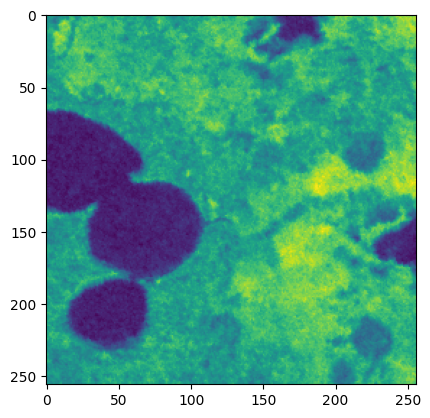

In [12]:
plt.imshow(train_images[2, :,:])

In [18]:
water_mask = load_stack_safely((I, N, M), np.int8, water_dir, "water")
poly_mask = load_stack_safely((I, N, M), np.int8, poly_dir, "polygonal")
trees_mask = load_stack_safely((I, N, M), np.int8, trees_dir, "tree")

skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_5.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_8.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_9.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_13.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_17.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_18.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_19.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_22.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_25.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_28.tif
skipping /media/studentuser/Seagate Portable Drive/training_test/masks/water/water_30.tif
skipping /med

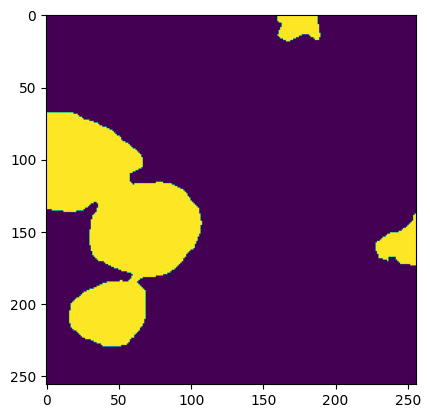

In [17]:
plt.imshow(water_mask[2, :,:])

In [19]:
model = satellite_unet((N, M, 1), 3)

2023-06-28 14:36:42.460264: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [24]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "binary_crossentropy",
    metrics = [iou, iou_thresholded],
)

In [21]:
W = 100
Y = np.zeros(shape=(W, N, M, 3), dtype =np.int8)
Y[:, :, :, 0] = trees_mask
Y[:, :, :, 1] = poly_mask
Y[:, :, :, 2] = water_mask

In [22]:
Y.shape

(100, 256, 256, 3)

In [25]:
history = model.fit(train_images.reshape(W, N, M, 1), Y, epochs = 150)

Epoch 1/150
4/4 [==============================] - 19s 3s/step - loss: 0.6336 - iou: 0.1402 - iou_thresholded: 0.1528
Epoch 2/150
4/4 [==============================] - 13s 3s/step - loss: 0.3404 - iou: 0.2323 - iou_thresholded: 0.3482
Epoch 3/150
4/4 [==============================] - 13s 3s/step - loss: 0.2851 - iou: 0.2447 - iou_thresholded: 0.2922
Epoch 4/150
4/4 [==============================] - 13s 3s/step - loss: 0.2675 - iou: 0.2918 - iou_thresholded: 0.3406
Epoch 5/150
4/4 [==============================] - 13s 3s/step - loss: 0.3160 - iou: 0.2450 - iou_thresholded: 0.2705
Epoch 6/150
4/4 [==============================] - 13s 3s/step - loss: 0.2606 - iou: 0.3002 - iou_thresholded: 0.3610
Epoch 7/150
4/4 [==============================] - 13s 3s/step - loss: 0.2483 - iou: 0.3505 - iou_thresholded: 0.4538
Epoch 8/150
4/4 [==============================] - 13s 3s/step - loss: 0.2524 - iou: 0.2892 - iou_thresholded: 0.3457
Epoch 9/150
4/4 [==============================] - 13s 3

4/4 [==============================] - 13s 3s/step - loss: 0.1618 - iou: 0.4382 - iou_thresholded: 0.5424
Epoch 70/150
4/4 [==============================] - 13s 3s/step - loss: 0.1417 - iou: 0.4826 - iou_thresholded: 0.6242
Epoch 71/150
4/4 [==============================] - 12s 3s/step - loss: 0.1409 - iou: 0.4938 - iou_thresholded: 0.6269
Epoch 72/150
4/4 [==============================] - 13s 3s/step - loss: 0.1417 - iou: 0.5177 - iou_thresholded: 0.6645
Epoch 73/150
4/4 [==============================] - 13s 3s/step - loss: 0.1728 - iou: 0.4522 - iou_thresholded: 0.5756
Epoch 74/150
4/4 [==============================] - 13s 3s/step - loss: 0.1539 - iou: 0.4758 - iou_thresholded: 0.5874
Epoch 75/150
4/4 [==============================] - 13s 3s/step - loss: 0.1485 - iou: 0.4602 - iou_thresholded: 0.5397
Epoch 76/150
4/4 [==============================] - 13s 3s/step - loss: 0.1409 - iou: 0.4918 - iou_thresholded: 0.6064
Epoch 77/150
4/4 [==============================] - 13s 3s/st

4/4 [==============================] - 13s 3s/step - loss: 0.1209 - iou: 0.5236 - iou_thresholded: 0.6695
Epoch 138/150
4/4 [==============================] - 13s 3s/step - loss: 0.1087 - iou: 0.5556 - iou_thresholded: 0.6884
Epoch 139/150
4/4 [==============================] - 13s 3s/step - loss: 0.0946 - iou: 0.5809 - iou_thresholded: 0.7289
Epoch 140/150
4/4 [==============================] - 13s 3s/step - loss: 0.0992 - iou: 0.5752 - iou_thresholded: 0.6911
Epoch 141/150
4/4 [==============================] - 13s 3s/step - loss: 0.0977 - iou: 0.5624 - iou_thresholded: 0.6717
Epoch 142/150
4/4 [==============================] - 13s 3s/step - loss: 0.0899 - iou: 0.6600 - iou_thresholded: 0.7697
Epoch 143/150
4/4 [==============================] - 13s 3s/step - loss: 0.1427 - iou: 0.5012 - iou_thresholded: 0.5718
Epoch 144/150
4/4 [==============================] - 13s 3s/step - loss: 0.1350 - iou: 0.5709 - iou_thresholded: 0.6749
Epoch 145/150
4/4 [==============================] - 1

In [31]:
Y_pred = model.predict(train_images.reshape(I, N, M, 1))

4/4 [==============================] - 5s 1s/step


In [32]:
Y_pred.shape, Y.shape

((100, 256, 256, 3), (100, 256, 256, 3))

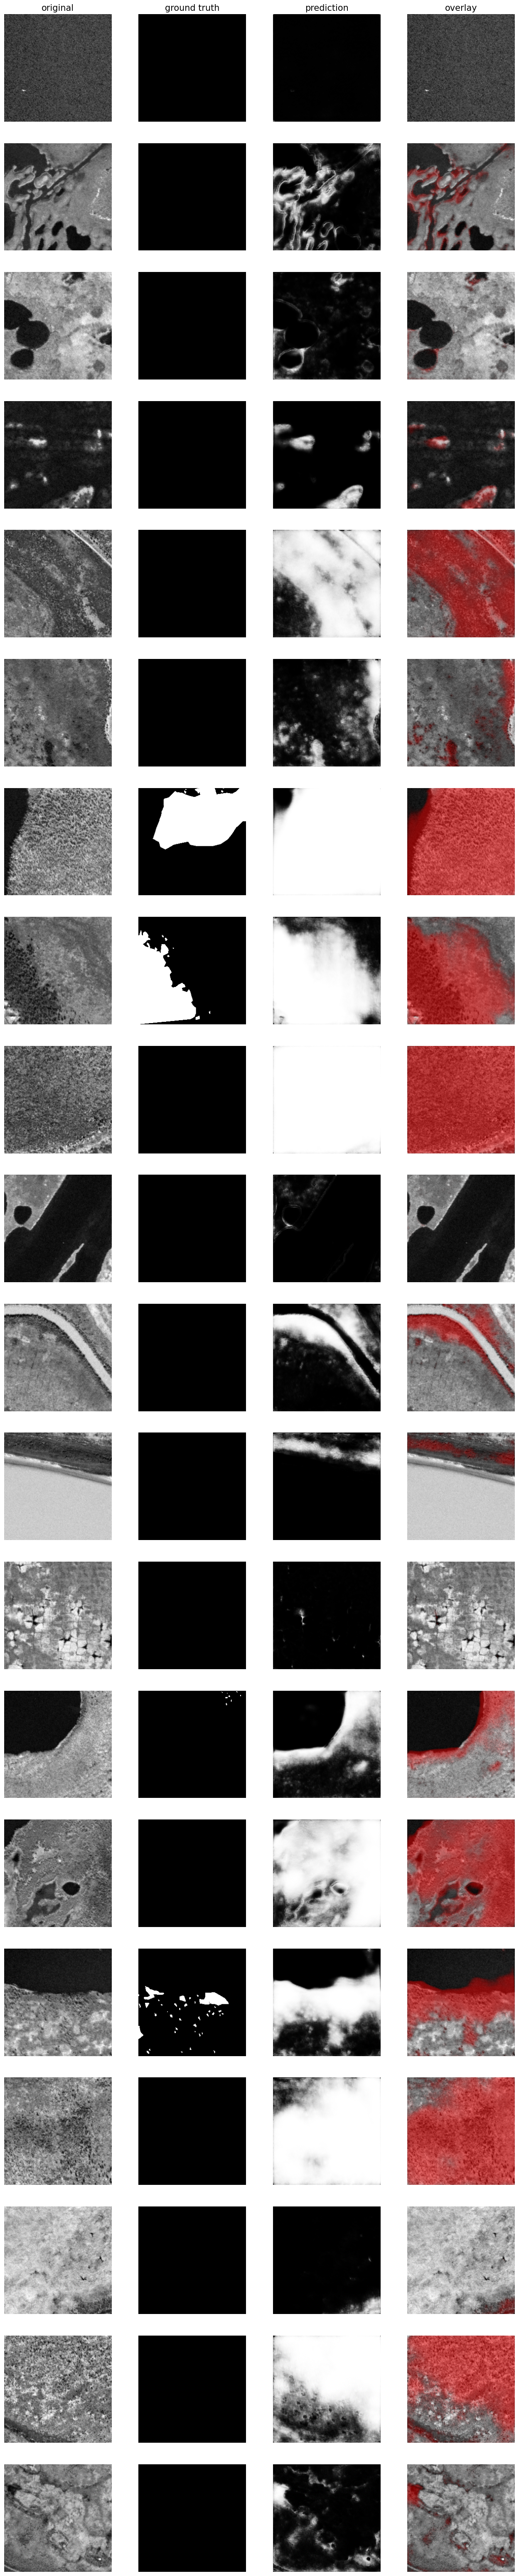

In [33]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 1), 
    mask_imgs=Y[:, :, :, 0], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=20
  )

In [34]:
plt.plot(history.history['iou'])

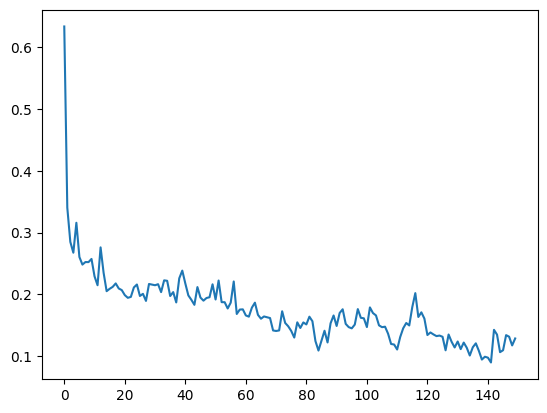

In [35]:
plt.plot(history.history['loss'])